In [5]:
%cd ..

Processing c:\cygwin64\home\evger\thesis


ERROR: Could not install packages due to an EnvironmentError: [('C:\\cygwin64\\home\\evger\\thesis\\venv\\lib', 'C:\\Users\\evger\\AppData\\Local\\Temp\\pip-req-build-eu_rt1w1\\venv\\lib', "[WinError 183] Cannot create a file when that file already exists: 'C:\\\\Users\\\\evger\\\\AppData\\\\Local\\\\Temp\\\\pip-req-build-eu_rt1w1\\\\venv\\\\lib'")]



In [6]:
from hft.environment import sampler
import pandas as pd
import glob
import os

ModuleNotFoundError: No module named 'hft'

In [51]:
dst_dir = 'time-sampled-10min'

In [52]:
if not os.path.exists(dst_dir):
    seconds = 600
    samplerr = sampler.TimeSampler('../tests/resources/may1/orderbooks/0.csv.gz',
                                   '../tests/resources/may1/trades/0.csv.gz',
                                   dst_dir, seconds, nrows=700000, max_workers=8)
    samplerr.split_samples()

2020-05-13 18:18:17,627 - <sampler> - INFO - Loaded TimeSampler
2020-05-13 18:18:19,904 - <sampler> - INFO - Task for file trade_1 finished
2020-05-13 18:18:20,137 - <sampler> - INFO - Task for file trade_2 finished
2020-05-13 18:18:20,415 - <sampler> - INFO - Task for file trade_0 finished
2020-05-13 18:18:21,093 - <sampler> - INFO - Task for file trade_3 finished
2020-05-13 18:18:21,673 - <sampler> - INFO - Task for file trade_4 finished
2020-05-13 18:18:24,793 - <sampler> - INFO - Task for file trade_5 finished
2020-05-13 18:18:26,195 - <sampler> - INFO - Task for file trade_6 finished
2020-05-13 18:18:58,805 - <sampler> - INFO - Task for file orderbook_4 finished
2020-05-13 18:18:59,795 - <sampler> - INFO - Task for file trade_7 finished
2020-05-13 18:19:04,456 - <sampler> - INFO - Task for file orderbook_7 finished
2020-05-13 18:19:06,299 - <sampler> - INFO - Task for file trade_8 finished
2020-05-13 18:19:08,219 - <sampler> - INFO - Task for file orderbook_1 finished
2020-05-13 1

2020-05-13 18:23:59,100 - <sampler> - INFO - Task for file trade_53 finished
2020-05-13 18:24:00,285 - <sampler> - INFO - Task for file trade_54 finished
2020-05-13 18:24:01,623 - <sampler> - INFO - Task for file orderbook_48 finished
2020-05-13 18:24:03,517 - <sampler> - INFO - Task for file trade_55 finished
2020-05-13 18:24:07,590 - <sampler> - INFO - Task for file orderbook_51 finished
2020-05-13 18:24:08,681 - <sampler> - INFO - Task for file trade_56 finished
2020-05-13 18:24:11,564 - <sampler> - INFO - Task for file orderbook_52 finished
2020-05-13 18:24:12,430 - <sampler> - INFO - Task for file trade_57 finished
2020-05-13 18:24:19,120 - <sampler> - INFO - Task for file orderbook_50 finished
2020-05-13 18:24:23,843 - <sampler> - INFO - Task for file orderbook_49 finished
2020-05-13 18:24:29,668 - <sampler> - INFO - Task for file orderbook_54 finished
2020-05-13 18:24:31,406 - <sampler> - INFO - Task for file orderbook_53 finished
2020-05-13 18:24:31,930 - <sampler> - INFO - Tas

2020-05-13 18:29:41,822 - <sampler> - INFO - Task for file orderbook_100 finished
2020-05-13 18:29:44,302 - <sampler> - INFO - Task for file orderbook_98 finished
2020-05-13 18:30:06,852 - <sampler> - INFO - Reload orderbook df
2020-05-13 18:30:09,309 - <sampler> - INFO - Task for file trade_104 finished
2020-05-13 18:30:09,371 - <sampler> - INFO - Task for file trade_103 finished
2020-05-13 18:30:09,777 - <sampler> - INFO - Task for file trade_105 finished
2020-05-13 18:30:10,662 - <sampler> - INFO - Task for file trade_102 finished
2020-05-13 18:30:11,229 - <sampler> - INFO - Task for file trade_106 finished
2020-05-13 18:30:12,136 - <sampler> - INFO - Task for file trade_107 finished
2020-05-13 18:30:14,537 - <sampler> - INFO - Task for file trade_108 finished
2020-05-13 18:30:54,859 - <sampler> - INFO - Task for file orderbook_107 finished
2020-05-13 18:30:57,484 - <sampler> - INFO - Task for file trade_109 finished
2020-05-13 18:30:57,726 - <sampler> - INFO - Task for file orderbo

2020-05-13 18:38:34,201 - <sampler> - INFO - Task for file orderbook_145 finished
2020-05-13 18:38:37,239 - <sampler> - INFO - Task for file orderbook_149 finished
2020-05-13 18:38:38,691 - <sampler> - INFO - Task for file orderbook_148 finished
2020-05-13 18:38:38,756 - <sampler> - INFO - Task for file orderbook_150 finished
2020-05-13 18:39:09,015 - <sampler> - INFO - Reload orderbook df
2020-05-13 18:39:11,623 - <sampler> - INFO - Task for file trade_154 finished
2020-05-13 18:39:12,236 - <sampler> - INFO - Task for file trade_155 finished
2020-05-13 18:39:12,396 - <sampler> - INFO - Task for file trade_153 finished
2020-05-13 18:39:13,435 - <sampler> - INFO - Task for file trade_152 finished
2020-05-13 18:39:14,336 - <sampler> - INFO - Task for file trade_156 finished
2020-05-13 18:39:16,078 - <sampler> - INFO - Task for file trade_157 finished
2020-05-13 18:39:18,103 - <sampler> - INFO - Task for file trade_158 finished
2020-05-13 18:39:57,825 - <sampler> - INFO - Task for file or

2020-05-13 18:47:00,255 - <sampler> - INFO - Task for file trade_199 finished
2020-05-13 18:47:03,583 - <sampler> - INFO - Task for file trade_198 finished
2020-05-13 18:47:05,762 - <sampler> - INFO - Task for file trade_202 finished
2020-05-13 18:47:06,016 - <sampler> - INFO - Task for file trade_203 finished
2020-05-13 18:47:08,213 - <sampler> - INFO - Task for file trade_204 finished
2020-05-13 18:47:37,251 - <sampler> - INFO - Task for file orderbook_204 finished
2020-05-13 18:47:57,391 - <sampler> - INFO - Task for file orderbook_200 finished
2020-05-13 18:48:07,580 - <sampler> - INFO - Task for file orderbook_203 finished
2020-05-13 18:48:10,737 - <sampler> - INFO - Task for file orderbook_201 finished
2020-05-13 18:48:15,345 - <sampler> - INFO - Task for file orderbook_199 finished
2020-05-13 18:48:17,148 - <sampler> - INFO - Task for file orderbook_202 finished
2020-05-13 18:48:19,740 - <sampler> - INFO - Task for file orderbook_198 finished
2020-05-13 18:48:56,019 - <sampler> 

2020-05-13 18:59:17,101 - <sampler> - INFO - Task for file orderbook_245 finished
2020-05-13 18:59:19,625 - <sampler> - INFO - Task for file orderbook_247 finished
2020-05-13 18:59:19,817 - <sampler> - INFO - Task for file orderbook_243 finished
2020-05-13 19:00:24,072 - <sampler> - INFO - Reload orderbook df
2020-05-13 19:00:34,920 - <sampler> - INFO - Task for file trade_249 finished
2020-05-13 19:00:39,958 - <sampler> - INFO - Task for file trade_250 finished
2020-05-13 19:00:48,216 - <sampler> - INFO - Task for file trade_252 finished
2020-05-13 19:00:54,631 - <sampler> - INFO - Task for file trade_251 finished
2020-05-13 19:01:01,022 - <sampler> - INFO - Task for file trade_253 finished
2020-05-13 19:01:13,205 - <sampler> - INFO - Task for file trade_254 finished
2020-05-13 19:01:19,208 - <sampler> - INFO - Task for file trade_255 finished
2020-05-13 19:01:41,373 - <sampler> - INFO - Task for file orderbook_252 finished
2020-05-13 19:01:59,778 - <sampler> - INFO - Task for file or

2020-05-13 19:18:09,496 - <sampler> - INFO - Task for file orderbook_298 finished
2020-05-13 19:18:12,500 - <sampler> - INFO - Task for file trade_299 finished
2020-05-13 19:18:13,602 - <sampler> - INFO - Task for file orderbook_297 finished
2020-05-13 19:18:14,559 - <sampler> - INFO - Task for file orderbook_299 finished
2020-05-13 19:18:16,078 - <sampler> - INFO - Task for file trade_300 finished
2020-05-13 19:18:17,107 - <sampler> - INFO - Task for file orderbook_296 finished
2020-05-13 19:18:18,584 - <sampler> - INFO - Task for file trade_301 finished
2020-05-13 19:18:20,003 - <sampler> - INFO - Task for file orderbook_295 finished
2020-05-13 19:18:20,746 - <sampler> - INFO - Task for file orderbook_292 finished
2020-05-13 19:18:24,658 - <sampler> - INFO - Task for file orderbook_294 finished
2020-05-13 19:18:26,486 - <sampler> - INFO - Task for file orderbook_301 finished
2020-05-13 19:18:27,936 - <sampler> - INFO - Task for file orderbook_293 finished
2020-05-13 19:18:32,420 - <s

2020-05-13 19:33:44,288 - <sampler> - INFO - Task for file trade_345 finished
2020-05-13 19:33:44,741 - <sampler> - INFO - Task for file trade_344 finished
2020-05-13 19:33:45,865 - <sampler> - INFO - Task for file trade_347 finished
2020-05-13 19:33:45,929 - <sampler> - INFO - Task for file trade_346 finished
2020-05-13 19:33:49,055 - <sampler> - INFO - Task for file trade_349 finished
2020-05-13 19:33:50,554 - <sampler> - INFO - Task for file trade_348 finished
2020-05-13 19:34:15,882 - <sampler> - INFO - Task for file orderbook_345 finished
2020-05-13 19:34:18,500 - <sampler> - INFO - Task for file orderbook_347 finished
2020-05-13 19:34:18,875 - <sampler> - INFO - Task for file orderbook_346 finished
2020-05-13 19:34:19,889 - <sampler> - INFO - Task for file orderbook_348 finished
2020-05-13 19:34:20,331 - <sampler> - INFO - Task for file orderbook_344 finished
2020-05-13 19:34:22,909 - <sampler> - INFO - Task for file orderbook_349 finished
2020-05-13 19:34:29,609 - <sampler> - IN

2020-05-13 19:42:18,597 - <sampler> - INFO - Task for file trade_395 finished
2020-05-13 19:42:20,665 - <sampler> - INFO - Task for file trade_396 finished
2020-05-13 19:42:23,942 - <sampler> - INFO - Task for file trade_397 finished
2020-05-13 19:42:31,774 - <sampler> - INFO - Task for file trade_398 finished
2020-05-13 19:42:44,613 - <sampler> - INFO - Task for file orderbook_393 finished
2020-05-13 19:42:47,346 - <sampler> - INFO - Task for file orderbook_392 finished
2020-05-13 19:42:48,395 - <sampler> - INFO - Task for file orderbook_394 finished
2020-05-13 19:42:50,986 - <sampler> - INFO - Task for file orderbook_395 finished
2020-05-13 19:42:53,021 - <sampler> - INFO - Task for file orderbook_396 finished
2020-05-13 19:42:55,059 - <sampler> - INFO - Task for file trade_400 finished
2020-05-13 19:42:56,016 - <sampler> - INFO - Task for file trade_399 finished
2020-05-13 19:42:58,653 - <sampler> - INFO - Task for file orderbook_397 finished
2020-05-13 19:43:02,347 - <sampler> - IN

2020-05-13 19:53:41,977 - <sampler> - INFO - Task for file trade_446 finished
2020-05-13 19:54:15,478 - <sampler> - INFO - Task for file orderbook_441 finished
2020-05-13 19:54:21,564 - <sampler> - INFO - Task for file trade_447 finished
2020-05-13 19:54:21,733 - <sampler> - INFO - Task for file orderbook_440 finished
2020-05-13 19:54:24,317 - <sampler> - INFO - Task for file orderbook_444 finished
2020-05-13 19:54:25,640 - <sampler> - INFO - Task for file orderbook_443 finished
2020-05-13 19:54:27,695 - <sampler> - INFO - Task for file orderbook_445 finished
2020-05-13 19:54:27,999 - <sampler> - INFO - Task for file trade_448 finished
2020-05-13 19:54:28,804 - <sampler> - INFO - Task for file trade_449 finished
2020-05-13 19:54:30,042 - <sampler> - INFO - Task for file trade_450 finished
2020-05-13 19:54:30,616 - <sampler> - INFO - Task for file orderbook_442 finished
2020-05-13 19:54:35,055 - <sampler> - INFO - Task for file orderbook_446 finished
2020-05-13 19:54:37,959 - <sampler> 

2020-05-13 20:05:46,423 - <sampler> - INFO - Task for file trade_494 finished
2020-05-13 20:05:48,073 - <sampler> - INFO - Task for file orderbook_488 finished
2020-05-13 20:05:48,174 - <sampler> - INFO - Task for file orderbook_486 finished
2020-05-13 20:05:48,283 - <sampler> - INFO - Task for file trade_495 finished
2020-05-13 20:05:49,450 - <sampler> - INFO - Task for file trade_496 finished
2020-05-13 20:05:51,814 - <sampler> - INFO - Task for file trade_497 finished
2020-05-13 20:05:53,067 - <sampler> - INFO - Task for file trade_498 finished
2020-05-13 20:05:54,432 - <sampler> - INFO - Task for file orderbook_493 finished
2020-05-13 20:05:55,598 - <sampler> - INFO - Task for file trade_499 finished
2020-05-13 20:05:57,637 - <sampler> - INFO - Task for file trade_500 finished
2020-05-13 20:06:28,656 - <sampler> - INFO - Task for file orderbook_497 finished
2020-05-13 20:06:29,993 - <sampler> - INFO - Task for file trade_501 finished
2020-05-13 20:06:30,892 - <sampler> - INFO - Tas

2020-05-13 20:14:26,821 - <sampler> - INFO - Task for file orderbook_541 finished
2020-05-13 20:14:28,759 - <sampler> - INFO - Task for file orderbook_542 finished
2020-05-13 20:14:29,018 - <sampler> - INFO - Task for file orderbook_539 finished
2020-05-13 20:14:30,840 - <sampler> - INFO - Task for file orderbook_544 finished
2020-05-13 20:16:53,435 - <sampler> - INFO - Reload orderbook df
2020-05-13 20:16:57,304 - <sampler> - INFO - Task for file trade_546 finished
2020-05-13 20:16:58,580 - <sampler> - INFO - Task for file trade_545 finished
2020-05-13 20:17:00,291 - <sampler> - INFO - Task for file trade_548 finished
2020-05-13 20:17:01,606 - <sampler> - INFO - Task for file trade_549 finished
2020-05-13 20:17:02,937 - <sampler> - INFO - Task for file trade_547 finished
2020-05-13 20:17:04,702 - <sampler> - INFO - Task for file trade_550 finished
2020-05-13 20:17:12,694 - <sampler> - INFO - Task for file trade_551 finished
2020-05-13 20:17:27,371 - <sampler> - INFO - Task for file or

2020-05-13 20:26:01,992 - <sampler> - INFO - Task for file trade_596 finished
2020-05-13 20:26:03,695 - <sampler> - INFO - Task for file orderbook_590 finished
2020-05-13 20:26:07,975 - <sampler> - INFO - Task for file trade_597 finished
2020-05-13 20:26:10,186 - <sampler> - INFO - Task for file orderbook_592 finished
2020-05-13 20:26:11,508 - <sampler> - INFO - Task for file orderbook_591 finished
2020-05-13 20:26:12,455 - <sampler> - INFO - Task for file trade_598 finished
2020-05-13 20:26:12,603 - <sampler> - INFO - Task for file orderbook_595 finished
2020-05-13 20:26:14,205 - <sampler> - INFO - Task for file orderbook_593 finished
2020-05-13 20:26:15,521 - <sampler> - INFO - Task for file trade_600 finished
2020-05-13 20:26:16,010 - <sampler> - INFO - Task for file trade_599 finished
2020-05-13 20:26:16,054 - <sampler> - INFO - Task for file orderbook_594 finished
2020-05-13 20:26:19,675 - <sampler> - INFO - Task for file orderbook_596 finished
2020-05-13 20:26:32,489 - <sampler> 

2020-05-13 20:37:00,388 - <sampler> - INFO - Task for file orderbook_643 finished
2020-05-13 20:37:00,705 - <sampler> - INFO - Task for file orderbook_642 finished
2020-05-13 20:37:11,497 - <sampler> - INFO - Reload trade df
2020-05-13 20:37:13,752 - <sampler> - INFO - Task for file trade_644 finished
2020-05-13 20:37:13,967 - <sampler> - INFO - Task for file trade_645 finished
2020-05-13 20:37:14,756 - <sampler> - INFO - Task for file trade_646 finished
2020-05-13 20:37:15,365 - <sampler> - INFO - Task for file trade_647 finished
2020-05-13 20:37:15,682 - <sampler> - INFO - Task for file trade_648 finished
2020-05-13 20:37:16,530 - <sampler> - INFO - Task for file trade_649 finished
2020-05-13 20:37:19,252 - <sampler> - INFO - Task for file trade_650 finished
2020-05-13 20:37:43,672 - <sampler> - INFO - Task for file orderbook_649 finished
2020-05-13 20:37:44,955 - <sampler> - INFO - Task for file trade_651 finished
2020-05-13 20:37:47,518 - <sampler> - INFO - Task for file orderbook_

2020-05-13 20:45:40,507 - <sampler> - INFO - Task for file orderbook_693 finished
2020-05-13 20:45:41,125 - <sampler> - INFO - Task for file orderbook_690 finished
2020-05-13 20:45:42,268 - <sampler> - INFO - Task for file orderbook_694 finished
2020-05-13 20:45:42,760 - <sampler> - INFO - Task for file orderbook_695 finished
2020-05-13 20:45:45,920 - <sampler> - INFO - Task for file orderbook_692 finished
2020-05-13 20:45:46,271 - <sampler> - INFO - Task for file trade_696 finished
2020-05-13 20:45:48,396 - <sampler> - INFO - Task for file trade_698 finished
2020-05-13 20:45:50,943 - <sampler> - INFO - Task for file trade_697 finished
2020-05-13 20:45:51,648 - <sampler> - INFO - Task for file trade_700 finished
2020-05-13 20:45:54,628 - <sampler> - INFO - Task for file trade_699 finished
2020-05-13 20:45:55,287 - <sampler> - INFO - Task for file trade_701 finished
2020-05-13 20:45:57,774 - <sampler> - INFO - Task for file trade_702 finished
2020-05-13 20:46:14,568 - <sampler> - INFO -

2020-05-13 20:56:31,991 - <sampler> - INFO - Task for file trade_744 finished
2020-05-13 20:56:32,048 - <sampler> - INFO - Task for file trade_745 finished
2020-05-13 20:56:32,303 - <sampler> - INFO - Task for file trade_746 finished
2020-05-13 20:56:33,127 - <sampler> - INFO - Task for file trade_747 finished
2020-05-13 20:56:33,832 - <sampler> - INFO - Task for file trade_748 finished
2020-05-13 20:56:34,797 - <sampler> - INFO - Task for file trade_749 finished
2020-05-13 20:56:50,120 - <sampler> - INFO - Task for file orderbook_750 finished
2020-05-13 20:56:50,747 - <sampler> - INFO - Task for file trade_750 finished
2020-05-13 20:56:55,463 - <sampler> - INFO - Task for file orderbook_747 finished
2020-05-13 20:56:55,972 - <sampler> - INFO - Task for file orderbook_746 finished
2020-05-13 20:56:56,296 - <sampler> - INFO - Task for file trade_751 finished
2020-05-13 20:56:57,917 - <sampler> - INFO - Task for file orderbook_749 finished
2020-05-13 20:56:58,623 - <sampler> - INFO - Tas

2020-05-13 21:07:45,008 - <sampler> - INFO - Task for file trade_795 finished
2020-05-13 21:07:45,031 - <sampler> - INFO - Task for file orderbook_784 finished
2020-05-13 21:07:46,272 - <sampler> - INFO - Task for file trade_796 finished
2020-05-13 21:07:47,437 - <sampler> - INFO - Task for file trade_797 finished
2020-05-13 21:07:48,781 - <sampler> - INFO - Task for file trade_798 finished
2020-05-13 21:08:06,562 - <sampler> - INFO - Task for file orderbook_793 finished
2020-05-13 21:08:07,216 - <sampler> - INFO - Task for file orderbook_794 finished
2020-05-13 21:08:07,560 - <sampler> - INFO - Task for file trade_799 finished
2020-05-13 21:08:09,295 - <sampler> - INFO - Task for file trade_800 finished
2020-05-13 21:08:13,124 - <sampler> - INFO - Task for file orderbook_792 finished
2020-05-13 21:08:15,562 - <sampler> - INFO - Task for file trade_801 finished
2020-05-13 21:08:15,639 - <sampler> - INFO - Task for file orderbook_799 finished
2020-05-13 21:08:16,289 - <sampler> - INFO -

2020-05-13 21:20:20,689 - <sampler> - INFO - Reload orderbook df
2020-05-13 21:20:22,302 - <sampler> - INFO - Task for file trade_845 finished
2020-05-13 21:20:26,208 - <sampler> - INFO - Task for file trade_843 finished
2020-05-13 21:20:28,800 - <sampler> - INFO - Task for file trade_844 finished
2020-05-13 21:20:45,235 - <sampler> - INFO - Task for file orderbook_843 finished
2020-05-13 21:20:48,099 - <sampler> - INFO - Task for file orderbook_845 finished
2020-05-13 21:20:49,999 - <sampler> - INFO - Task for file orderbook_844 finished
2020-05-13 21:20:56,820 - <sampler> - INFO - Reload trade df
2020-05-13 21:21:00,247 - <sampler> - INFO - Task for file trade_846 finished
2020-05-13 21:21:00,875 - <sampler> - INFO - Task for file trade_848 finished
2020-05-13 21:21:02,237 - <sampler> - INFO - Task for file trade_847 finished
2020-05-13 21:21:04,980 - <sampler> - INFO - Task for file trade_849 finished
2020-05-13 21:21:05,282 - <sampler> - INFO - Task for file trade_850 finished
2020

2020-05-13 21:35:44,209 - <sampler> - INFO - Task for file trade_894 finished
2020-05-13 21:36:22,358 - <sampler> - INFO - Task for file orderbook_895 finished
2020-05-13 21:36:22,569 - <sampler> - INFO - Task for file orderbook_894 finished
2020-05-13 21:36:23,934 - <sampler> - INFO - Task for file orderbook_891 finished
2020-05-13 21:36:24,001 - <sampler> - INFO - Task for file trade_895 finished
2020-05-13 21:36:24,229 - <sampler> - INFO - Task for file orderbook_892 finished
2020-05-13 21:36:27,074 - <sampler> - INFO - Task for file trade_896 finished
2020-05-13 21:36:27,810 - <sampler> - INFO - Task for file trade_897 finished
2020-05-13 21:36:30,468 - <sampler> - INFO - Task for file trade_898 finished
2020-05-13 21:36:30,471 - <sampler> - INFO - Task for file orderbook_893 finished
2020-05-13 21:36:32,207 - <sampler> - INFO - Task for file orderbook_890 finished
2020-05-13 21:36:33,813 - <sampler> - INFO - Task for file orderbook_889 finished
2020-05-13 21:36:35,298 - <sampler> 

2020-05-13 21:48:46,909 - <sampler> - INFO - Task for file trade_943 finished
2020-05-13 21:48:47,784 - <sampler> - INFO - Task for file trade_942 finished
2020-05-13 21:48:49,032 - <sampler> - INFO - Task for file trade_941 finished
2020-05-13 21:48:49,339 - <sampler> - INFO - Task for file trade_940 finished
2020-05-13 21:48:49,758 - <sampler> - INFO - Task for file trade_944 finished
2020-05-13 21:49:01,257 - <sampler> - INFO - Task for file orderbook_944 finished
2020-05-13 21:49:21,825 - <sampler> - INFO - Task for file orderbook_943 finished
2020-05-13 21:49:23,100 - <sampler> - INFO - Task for file orderbook_942 finished
2020-05-13 21:49:23,130 - <sampler> - INFO - Task for file orderbook_940 finished
2020-05-13 21:49:25,403 - <sampler> - INFO - Task for file orderbook_941 finished
2020-05-13 21:51:24,504 - <sampler> - INFO - Reload orderbook df
2020-05-13 21:51:26,408 - <sampler> - INFO - Task for file trade_945 finished
2020-05-13 21:51:27,690 - <sampler> - INFO - Task for fil

2020-05-13 22:01:51,960 - <sampler> - INFO - Task for file orderbook_989 finished
2020-05-13 22:01:53,883 - <sampler> - INFO - Task for file orderbook_987 finished
2020-05-13 22:01:54,128 - <sampler> - INFO - Task for file trade_993 finished
2020-05-13 22:01:54,278 - <sampler> - INFO - Task for file orderbook_988 finished
2020-05-13 22:01:55,184 - <sampler> - INFO - Task for file orderbook_986 finished
2020-05-13 22:01:56,202 - <sampler> - INFO - Task for file trade_994 finished
2020-05-13 22:01:57,341 - <sampler> - INFO - Task for file trade_995 finished
2020-05-13 22:01:59,076 - <sampler> - INFO - Task for file trade_996 finished
2020-05-13 22:02:02,750 - <sampler> - INFO - Task for file orderbook_990 finished
2020-05-13 22:02:04,274 - <sampler> - INFO - Task for file orderbook_993 finished
2020-05-13 22:02:04,645 - <sampler> - INFO - Task for file orderbook_991 finished
2020-05-13 22:02:04,710 - <sampler> - INFO - Task for file trade_997 finished
2020-05-13 22:02:05,772 - <sampler> 

2020-05-14 08:38:57,129 - <sampler> - INFO - Task for file orderbook_1036 finished
2020-05-14 08:38:59,845 - <sampler> - INFO - Task for file orderbook_1035 finished
2020-05-14 08:39:06,583 - <sampler> - INFO - Task for file orderbook_1034 finished
2020-05-14 08:39:08,611 - <sampler> - INFO - Task for file orderbook_1033 finished
2020-05-14 08:39:16,027 - <sampler> - INFO - Task for file orderbook_1040 finished
2020-05-14 08:43:06,311 - <sampler> - INFO - Reload orderbook df
2020-05-14 08:43:07,434 - <sampler> - INFO - Task for file trade_1041 finished
2020-05-14 08:43:08,659 - <sampler> - INFO - Task for file trade_1042 finished
2020-05-14 08:43:08,834 - <sampler> - INFO - Task for file trade_1043 finished
2020-05-14 08:43:09,731 - <sampler> - INFO - Task for file trade_1044 finished
2020-05-14 08:43:11,009 - <sampler> - INFO - Task for file trade_1045 finished
2020-05-14 08:43:11,418 - <sampler> - INFO - Task for file trade_1046 finished
2020-05-14 08:43:14,018 - <sampler> - INFO - T

2020-05-14 08:55:28,871 - <sampler> - INFO - Task for file orderbook_1083 finished
2020-05-14 08:55:29,995 - <sampler> - INFO - Task for file orderbook_1085 finished
2020-05-14 08:55:33,284 - <sampler> - INFO - Task for file orderbook_1082 finished
2020-05-14 08:55:36,139 - <sampler> - INFO - Task for file orderbook_1087 finished
2020-05-14 08:55:36,427 - <sampler> - INFO - Task for file orderbook_1090 finished
2020-05-14 08:55:38,749 - <sampler> - INFO - Task for file orderbook_1088 finished
2020-05-14 08:55:39,715 - <sampler> - INFO - Task for file orderbook_1089 finished
2020-05-14 08:58:07,861 - <sampler> - INFO - Reload orderbook df
2020-05-14 08:58:09,138 - <sampler> - INFO - Task for file trade_1091 finished
2020-05-14 08:58:09,369 - <sampler> - INFO - Task for file trade_1093 finished
2020-05-14 08:58:09,442 - <sampler> - INFO - Task for file trade_1092 finished
2020-05-14 08:58:10,223 - <sampler> - INFO - Task for file trade_1094 finished
2020-05-14 08:58:11,167 - <sampler> - 

2020-05-14 09:09:34,008 - <sampler> - INFO - Task for file trade_1139 finished
2020-05-14 09:09:37,853 - <sampler> - INFO - Task for file trade_1140 finished
2020-05-14 09:10:09,852 - <sampler> - INFO - Task for file orderbook_1138 finished
2020-05-14 09:10:11,491 - <sampler> - INFO - Task for file trade_1141 finished
2020-05-14 09:10:16,833 - <sampler> - INFO - Task for file orderbook_1136 finished
2020-05-14 09:10:18,531 - <sampler> - INFO - Task for file trade_1142 finished
2020-05-14 09:10:20,633 - <sampler> - INFO - Task for file orderbook_1137 finished
2020-05-14 09:10:22,553 - <sampler> - INFO - Task for file trade_1143 finished
2020-05-14 09:10:24,585 - <sampler> - INFO - Task for file orderbook_1141 finished
2020-05-14 09:10:27,603 - <sampler> - INFO - Task for file trade_1144 finished
2020-05-14 09:10:31,270 - <sampler> - INFO - Task for file orderbook_1139 finished
2020-05-14 09:10:32,980 - <sampler> - INFO - Task for file orderbook_1135 finished
2020-05-14 09:10:36,129 - <s

2020-05-14 09:35:07,305 - <sampler> - INFO - Task for file trade_1186 finished
2020-05-14 09:35:08,620 - <sampler> - INFO - Task for file trade_1187 finished
2020-05-14 09:35:13,464 - <sampler> - INFO - Task for file trade_1185 finished
2020-05-14 09:35:17,546 - <sampler> - INFO - Task for file trade_1188 finished
2020-05-14 09:35:21,933 - <sampler> - INFO - Task for file trade_1189 finished
2020-05-14 09:35:27,985 - <sampler> - INFO - Task for file trade_1190 finished
2020-05-14 09:35:59,251 - <sampler> - INFO - Task for file orderbook_1191 finished
2020-05-14 09:36:05,768 - <sampler> - INFO - Task for file trade_1191 finished
2020-05-14 09:36:41,972 - <sampler> - INFO - Task for file orderbook_1184 finished
2020-05-14 09:36:49,277 - <sampler> - INFO - Task for file orderbook_1186 finished
2020-05-14 09:36:59,391 - <sampler> - INFO - Task for file orderbook_1187 finished
2020-05-14 09:37:06,369 - <sampler> - INFO - Task for file orderbook_1188 finished
2020-05-14 09:37:06,530 - <sampl

2020-05-14 10:01:07,346 - <sampler> - INFO - Task for file orderbook_1230 finished
2020-05-14 10:01:10,114 - <sampler> - INFO - Task for file trade_1237 finished
2020-05-14 10:01:14,444 - <sampler> - INFO - Task for file orderbook_1231 finished
2020-05-14 10:01:15,029 - <sampler> - INFO - Task for file orderbook_1232 finished
2020-05-14 10:01:19,041 - <sampler> - INFO - Task for file trade_1238 finished
2020-05-14 10:01:21,297 - <sampler> - INFO - Task for file orderbook_1233 finished
2020-05-14 10:01:22,004 - <sampler> - INFO - Task for file trade_1239 finished
2020-05-14 10:01:25,000 - <sampler> - INFO - Task for file trade_1240 finished
2020-05-14 10:01:47,691 - <sampler> - INFO - Task for file orderbook_1236 finished
2020-05-14 10:01:50,593 - <sampler> - INFO - Task for file trade_1241 finished
2020-05-14 10:01:52,619 - <sampler> - INFO - Task for file orderbook_1237 finished
2020-05-14 10:02:07,230 - <sampler> - INFO - Task for file orderbook_1235 finished
2020-05-14 10:02:13,134 

2020-05-14 10:21:50,653 - <sampler> - INFO - Task for file orderbook_1285 finished
2020-05-14 10:22:08,967 - <sampler> - INFO - Task for file orderbook_1280 finished
2020-05-14 10:22:11,471 - <sampler> - INFO - Task for file orderbook_1284 finished
2020-05-14 10:22:17,258 - <sampler> - INFO - Task for file orderbook_1283 finished
2020-05-14 10:22:17,677 - <sampler> - INFO - Task for file orderbook_1281 finished
2020-05-14 10:22:17,850 - <sampler> - INFO - Task for file orderbook_1282 finished
2020-05-14 10:25:32,931 - <sampler> - INFO - Reload orderbook df
2020-05-14 10:25:35,045 - <sampler> - INFO - Task for file trade_1288 finished
2020-05-14 10:25:35,108 - <sampler> - INFO - Task for file trade_1287 finished
2020-05-14 10:25:35,162 - <sampler> - INFO - Task for file trade_1286 finished
2020-05-14 10:25:49,686 - <sampler> - INFO - Task for file orderbook_1287 finished
2020-05-14 10:25:52,486 - <sampler> - INFO - Task for file orderbook_1288 finished
2020-05-14 10:25:53,533 - <sampler

2020-05-14 10:42:49,118 - <sampler> - INFO - Task for file orderbook_1330 finished
2020-05-14 10:42:50,602 - <sampler> - INFO - Task for file orderbook_1324 finished
2020-05-14 10:42:56,041 - <sampler> - INFO - Task for file orderbook_1331 finished
2020-05-14 10:42:59,062 - <sampler> - INFO - Task for file orderbook_1332 finished
2020-05-14 10:46:18,645 - <sampler> - INFO - Reload orderbook df
2020-05-14 10:46:22,332 - <sampler> - INFO - Task for file trade_1333 finished
2020-05-14 10:46:25,930 - <sampler> - INFO - Task for file trade_1334 finished
2020-05-14 10:46:28,403 - <sampler> - INFO - Task for file trade_1335 finished
2020-05-14 10:46:28,630 - <sampler> - INFO - Task for file trade_1336 finished
2020-05-14 10:46:35,312 - <sampler> - INFO - Task for file trade_1338 finished
2020-05-14 10:46:41,970 - <sampler> - INFO - Task for file trade_1337 finished
2020-05-14 10:47:21,626 - <sampler> - INFO - Task for file orderbook_1333 finished
2020-05-14 10:47:33,771 - <sampler> - INFO - T

2020-05-14 11:08:54,450 - <sampler> - INFO - Task for file orderbook_1377 finished
2020-05-14 11:08:58,745 - <sampler> - INFO - Task for file orderbook_1380 finished
2020-05-14 11:08:59,077 - <sampler> - INFO - Task for file orderbook_1378 finished
2020-05-14 11:09:00,498 - <sampler> - INFO - Task for file orderbook_1379 finished
2020-05-14 11:09:09,504 - <sampler> - INFO - Reload trade df
2020-05-14 11:09:10,990 - <sampler> - INFO - Task for file trade_1381 finished
2020-05-14 11:09:11,454 - <sampler> - INFO - Task for file trade_1382 finished
2020-05-14 11:09:11,485 - <sampler> - INFO - Task for file trade_1383 finished
2020-05-14 11:09:12,680 - <sampler> - INFO - Task for file trade_1384 finished
2020-05-14 11:09:32,962 - <sampler> - INFO - Task for file orderbook_1384 finished
2020-05-14 11:09:33,937 - <sampler> - INFO - Task for file orderbook_1383 finished
2020-05-14 11:09:35,617 - <sampler> - INFO - Task for file orderbook_1382 finished
2020-05-14 11:09:35,651 - <sampler> - INFO

2020-05-14 11:25:02,003 - <sampler> - INFO - Task for file orderbook_1423 finished
2020-05-14 11:25:02,791 - <sampler> - INFO - Task for file trade_1431 finished
2020-05-14 11:25:04,172 - <sampler> - INFO - Task for file trade_1432 finished
2020-05-14 11:25:05,198 - <sampler> - INFO - Task for file orderbook_1422 finished
2020-05-14 11:25:07,722 - <sampler> - INFO - Task for file trade_1433 finished
2020-05-14 11:25:09,564 - <sampler> - INFO - Task for file orderbook_1429 finished
2020-05-14 11:25:10,871 - <sampler> - INFO - Task for file orderbook_1428 finished
2020-05-14 11:25:11,400 - <sampler> - INFO - Task for file trade_1434 finished
2020-05-14 11:25:13,247 - <sampler> - INFO - Task for file orderbook_1425 finished
2020-05-14 11:25:17,074 - <sampler> - INFO - Task for file orderbook_1434 finished
2020-05-14 11:25:26,825 - <sampler> - INFO - Task for file orderbook_1430 finished
2020-05-14 11:25:28,359 - <sampler> - INFO - Task for file orderbook_1431 finished
2020-05-14 11:25:30,

2020-05-14 11:50:53,420 - <sampler> - INFO - Task for file orderbook_1473 finished
2020-05-14 11:51:05,293 - <sampler> - INFO - Task for file orderbook_1478 finished
2020-05-14 11:51:05,837 - <sampler> - INFO - Task for file orderbook_1475 finished
2020-05-14 11:51:05,869 - <sampler> - INFO - Task for file orderbook_1474 finished
2020-05-14 11:51:05,964 - <sampler> - INFO - Task for file orderbook_1476 finished
2020-05-14 11:51:06,296 - <sampler> - INFO - Task for file orderbook_1472 finished
2020-05-14 11:51:06,725 - <sampler> - INFO - Task for file orderbook_1477 finished
2020-05-14 11:54:01,168 - <sampler> - INFO - Reload orderbook df
2020-05-14 11:54:03,417 - <sampler> - INFO - Task for file trade_1479 finished
2020-05-14 11:54:04,319 - <sampler> - INFO - Task for file trade_1480 finished
2020-05-14 11:54:05,429 - <sampler> - INFO - Task for file trade_1481 finished
2020-05-14 11:54:05,857 - <sampler> - INFO - Task for file trade_1482 finished
2020-05-14 11:54:06,459 - <sampler> - 

2020-05-14 12:16:00,007 - <sampler> - INFO - Task for file orderbook_1519 finished
2020-05-14 12:16:01,770 - <sampler> - INFO - Task for file orderbook_1523 finished
2020-05-14 12:16:03,744 - <sampler> - INFO - Task for file orderbook_1518 finished
2020-05-14 12:16:04,856 - <sampler> - INFO - Task for file orderbook_1517 finished
2020-05-14 12:19:22,201 - <sampler> - INFO - Reload orderbook df
2020-05-14 12:19:24,703 - <sampler> - INFO - Task for file trade_1525 finished
2020-05-14 12:19:27,226 - <sampler> - INFO - Task for file trade_1528 finished
2020-05-14 12:19:29,048 - <sampler> - INFO - Task for file trade_1527 finished
2020-05-14 12:19:29,682 - <sampler> - INFO - Task for file trade_1526 finished
2020-05-14 12:19:32,084 - <sampler> - INFO - Task for file trade_1529 finished
2020-05-14 12:19:32,685 - <sampler> - INFO - Task for file trade_1530 finished
2020-05-14 12:19:36,263 - <sampler> - INFO - Task for file trade_1531 finished
2020-05-14 12:19:45,726 - <sampler> - INFO - Task 

2020-05-14 12:43:16,981 - <sampler> - INFO - Task for file trade_1574 finished
2020-05-14 12:43:18,448 - <sampler> - INFO - Task for file orderbook_1569 finished
2020-05-14 12:43:24,229 - <sampler> - INFO - Task for file trade_1575 finished
2020-05-14 12:43:24,464 - <sampler> - INFO - Task for file orderbook_1570 finished
2020-05-14 12:43:26,304 - <sampler> - INFO - Task for file orderbook_1574 finished
2020-05-14 12:43:27,184 - <sampler> - INFO - Task for file orderbook_1573 finished
2020-05-14 12:43:32,657 - <sampler> - INFO - Task for file orderbook_1572 finished
2020-05-14 12:43:32,674 - <sampler> - INFO - Task for file orderbook_1567 finished
2020-05-14 12:43:33,021 - <sampler> - INFO - Task for file orderbook_1571 finished
2020-05-14 12:43:46,335 - <sampler> - INFO - Task for file orderbook_1575 finished
2020-05-14 12:53:43,347 - <sampler> - INFO - Reload orderbook df
2020-05-14 12:53:46,013 - <sampler> - INFO - Task for file trade_1577 finished
2020-05-14 12:53:46,099 - <sampler

2020-05-14 13:14:42,296 - <sampler> - INFO - Task for file orderbook_1617 finished
2020-05-14 13:14:43,351 - <sampler> - INFO - Task for file orderbook_1619 finished
2020-05-14 13:14:43,661 - <sampler> - INFO - Task for file orderbook_1616 finished
2020-05-14 13:19:12,028 - <sampler> - INFO - Reload orderbook df
2020-05-14 13:19:17,047 - <sampler> - INFO - Task for file trade_1621 finished
2020-05-14 13:19:17,147 - <sampler> - INFO - Task for file trade_1622 finished
2020-05-14 13:19:19,987 - <sampler> - INFO - Task for file trade_1624 finished
2020-05-14 13:19:21,204 - <sampler> - INFO - Task for file trade_1623 finished
2020-05-14 13:19:25,359 - <sampler> - INFO - Task for file trade_1625 finished
2020-05-14 13:19:25,704 - <sampler> - INFO - Task for file trade_1626 finished
2020-05-14 13:19:28,181 - <sampler> - INFO - Task for file trade_1627 finished
2020-05-14 13:20:33,462 - <sampler> - INFO - Task for file orderbook_1624 finished
2020-05-14 13:20:36,024 - <sampler> - INFO - Task 

2020-05-14 13:56:24,050 - <sampler> - INFO - Reload orderbook df
2020-05-14 13:56:26,342 - <sampler> - INFO - Task for file trade_1668 finished
2020-05-14 13:56:26,772 - <sampler> - INFO - Task for file trade_1670 finished
2020-05-14 13:56:27,262 - <sampler> - INFO - Task for file trade_1669 finished
2020-05-14 13:56:32,981 - <sampler> - INFO - Task for file trade_1672 finished
2020-05-14 13:56:34,652 - <sampler> - INFO - Task for file trade_1671 finished
2020-05-14 13:56:38,266 - <sampler> - INFO - Task for file trade_1673 finished
2020-05-14 13:56:42,085 - <sampler> - INFO - Task for file trade_1674 finished
2020-05-14 13:57:12,220 - <sampler> - INFO - Task for file orderbook_1670 finished
2020-05-14 13:57:14,390 - <sampler> - INFO - Task for file trade_1675 finished
2020-05-14 13:57:29,805 - <sampler> - INFO - Task for file orderbook_1669 finished
2020-05-14 13:57:31,367 - <sampler> - INFO - Task for file trade_1676 finished
2020-05-14 13:57:33,125 - <sampler> - INFO - Task for file

2020-05-14 14:30:54,465 - <sampler> - INFO - Task for file orderbook_1714 finished
2020-05-14 14:30:55,800 - <sampler> - INFO - Task for file orderbook_1717 finished
2020-05-14 14:30:56,719 - <sampler> - INFO - Task for file orderbook_1716 finished
2020-05-14 14:34:53,324 - <sampler> - INFO - Reload orderbook df
2020-05-14 14:34:54,488 - <sampler> - INFO - Task for file trade_1718 finished
2020-05-14 14:34:54,743 - <sampler> - INFO - Task for file trade_1719 finished
2020-05-14 14:34:55,339 - <sampler> - INFO - Task for file trade_1720 finished
2020-05-14 14:34:56,057 - <sampler> - INFO - Task for file trade_1721 finished
2020-05-14 14:34:56,160 - <sampler> - INFO - Task for file trade_1722 finished
2020-05-14 14:34:57,858 - <sampler> - INFO - Task for file trade_1723 finished
2020-05-14 14:34:59,530 - <sampler> - INFO - Task for file trade_1724 finished
2020-05-14 14:35:37,662 - <sampler> - INFO - Task for file orderbook_1719 finished
2020-05-14 14:35:38,749 - <sampler> - INFO - Task 

2020-05-14 14:58:20,298 - <sampler> - INFO - Task for file trade_1765 finished
2020-05-14 14:58:24,790 - <sampler> - INFO - Task for file trade_1768 finished
2020-05-14 14:58:30,023 - <sampler> - INFO - Task for file trade_1767 finished
2020-05-14 14:58:32,655 - <sampler> - INFO - Task for file trade_1769 finished
2020-05-14 14:58:38,119 - <sampler> - INFO - Task for file trade_1770 finished
2020-05-14 14:59:19,773 - <sampler> - INFO - Task for file orderbook_1766 finished
2020-05-14 14:59:20,338 - <sampler> - INFO - Task for file orderbook_1765 finished
2020-05-14 14:59:20,740 - <sampler> - INFO - Task for file orderbook_1764 finished
2020-05-14 14:59:37,927 - <sampler> - INFO - Task for file orderbook_1768 finished
2020-05-14 14:59:38,565 - <sampler> - INFO - Task for file orderbook_1770 finished
2020-05-14 14:59:44,487 - <sampler> - INFO - Task for file orderbook_1767 finished
2020-05-14 14:59:45,262 - <sampler> - INFO - Task for file orderbook_1769 finished
2020-05-14 15:03:59,650 

2020-05-14 15:25:14,871 - <sampler> - INFO - Task for file orderbook_1812 finished
2020-05-14 15:25:15,438 - <sampler> - INFO - Task for file orderbook_1811 finished
2020-05-14 15:25:15,756 - <sampler> - INFO - Task for file orderbook_1813 finished
2020-05-14 15:25:20,074 - <sampler> - INFO - Task for file orderbook_1809 finished
2020-05-14 15:25:21,610 - <sampler> - INFO - Task for file orderbook_1810 finished
2020-05-14 15:29:11,593 - <sampler> - INFO - Reload orderbook df
2020-05-14 15:29:13,582 - <sampler> - INFO - Task for file trade_1816 finished
2020-05-14 15:29:14,659 - <sampler> - INFO - Task for file trade_1817 finished
2020-05-14 15:29:16,810 - <sampler> - INFO - Task for file trade_1820 finished
2020-05-14 15:29:18,772 - <sampler> - INFO - Task for file trade_1818 finished
2020-05-14 15:29:19,140 - <sampler> - INFO - Task for file trade_1819 finished
2020-05-14 15:29:20,850 - <sampler> - INFO - Task for file trade_1821 finished
2020-05-14 15:29:22,016 - <sampler> - INFO - T

2020-05-14 16:01:54,120 - <sampler> - INFO - Task for file orderbook_1864 finished
2020-05-14 16:01:57,309 - <sampler> - INFO - Task for file trade_1865 finished
2020-05-14 16:01:58,075 - <sampler> - INFO - Task for file orderbook_1858 finished
2020-05-14 16:02:01,161 - <sampler> - INFO - Task for file orderbook_1861 finished
2020-05-14 16:02:02,817 - <sampler> - INFO - Task for file trade_1866 finished
2020-05-14 16:02:04,800 - <sampler> - INFO - Task for file trade_1867 finished
2020-05-14 16:02:05,340 - <sampler> - INFO - Task for file orderbook_1865 finished
2020-05-14 16:02:05,524 - <sampler> - INFO - Task for file orderbook_1859 finished
2020-05-14 16:02:09,761 - <sampler> - INFO - Task for file orderbook_1862 finished
2020-05-14 16:02:14,521 - <sampler> - INFO - Task for file orderbook_1860 finished
2020-05-14 16:02:15,918 - <sampler> - INFO - Task for file orderbook_1863 finished
2020-05-14 16:02:33,780 - <sampler> - INFO - Task for file orderbook_1866 finished
2020-05-14 16:02

2020-05-14 16:40:12,417 - <sampler> - INFO - Task for file orderbook_1907 finished
2020-05-14 16:40:13,791 - <sampler> - INFO - Task for file trade_1913 finished
2020-05-14 16:40:16,981 - <sampler> - INFO - Task for file orderbook_1909 finished
2020-05-14 16:40:18,100 - <sampler> - INFO - Task for file orderbook_1903 finished
2020-05-14 16:40:24,503 - <sampler> - INFO - Task for file orderbook_1911 finished
2020-05-14 16:40:25,559 - <sampler> - INFO - Task for file orderbook_1913 finished
2020-05-14 16:40:26,588 - <sampler> - INFO - Task for file orderbook_1912 finished
2020-05-14 16:44:47,428 - <sampler> - INFO - Reload orderbook df
2020-05-14 16:44:50,020 - <sampler> - INFO - Task for file trade_1915 finished
2020-05-14 16:44:50,608 - <sampler> - INFO - Task for file trade_1916 finished
2020-05-14 16:44:50,849 - <sampler> - INFO - Task for file trade_1917 finished
2020-05-14 16:44:51,348 - <sampler> - INFO - Task for file trade_1914 finished
2020-05-14 16:44:52,201 - <sampler> - INFO

2020-05-14 17:18:25,886 - <sampler> - INFO - Task for file orderbook_1954 finished
2020-05-14 17:18:30,501 - <sampler> - INFO - Task for file orderbook_1953 finished
2020-05-14 17:18:30,897 - <sampler> - INFO - Task for file orderbook_1952 finished
2020-05-14 17:18:30,966 - <sampler> - INFO - Task for file orderbook_1958 finished
2020-05-14 17:23:06,705 - <sampler> - INFO - Reload orderbook df
2020-05-14 17:23:08,042 - <sampler> - INFO - Task for file trade_1960 finished
2020-05-14 17:23:09,000 - <sampler> - INFO - Task for file trade_1962 finished
2020-05-14 17:23:09,098 - <sampler> - INFO - Task for file trade_1961 finished
2020-05-14 17:23:10,370 - <sampler> - INFO - Task for file trade_1964 finished
2020-05-14 17:23:11,102 - <sampler> - INFO - Task for file trade_1963 finished
2020-05-14 17:23:12,017 - <sampler> - INFO - Task for file trade_1965 finished
2020-05-14 17:23:13,114 - <sampler> - INFO - Task for file trade_1966 finished
2020-05-14 17:23:55,035 - <sampler> - INFO - Task 

2020-05-14 17:48:21,581 - <sampler> - INFO - Task for file orderbook_2002 finished
2020-05-14 17:48:21,678 - <sampler> - INFO - Task for file orderbook_2004 finished
2020-05-14 17:48:21,795 - <sampler> - INFO - Task for file orderbook_2005 finished
2020-05-14 17:48:26,931 - <sampler> - INFO - Task for file orderbook_2000 finished
2020-05-14 17:48:28,006 - <sampler> - INFO - Task for file orderbook_2008 finished
2020-05-14 17:53:07,518 - <sampler> - INFO - Reload orderbook df
2020-05-14 17:53:09,375 - <sampler> - INFO - Task for file trade_2009 finished
2020-05-14 17:53:10,059 - <sampler> - INFO - Task for file trade_2010 finished
2020-05-14 17:53:10,898 - <sampler> - INFO - Task for file trade_2012 finished
2020-05-14 17:53:11,255 - <sampler> - INFO - Task for file trade_2011 finished
2020-05-14 17:53:11,979 - <sampler> - INFO - Task for file trade_2013 finished
2020-05-14 17:53:12,772 - <sampler> - INFO - Task for file trade_2014 finished
2020-05-14 17:53:14,484 - <sampler> - INFO - T

2020-05-14 18:17:41,148 - <sampler> - INFO - Task for file trade_2058 finished
2020-05-14 18:18:35,170 - <sampler> - INFO - Task for file orderbook_2057 finished
2020-05-14 18:18:37,595 - <sampler> - INFO - Task for file orderbook_2059 finished
2020-05-14 18:18:37,800 - <sampler> - INFO - Task for file trade_2059 finished
2020-05-14 18:18:37,819 - <sampler> - INFO - Task for file orderbook_2056 finished
2020-05-14 18:18:42,390 - <sampler> - INFO - Task for file orderbook_2054 finished
2020-05-14 18:18:43,450 - <sampler> - INFO - Task for file orderbook_2055 finished
2020-05-14 18:18:44,130 - <sampler> - INFO - Task for file orderbook_2058 finished
2020-05-14 18:18:45,509 - <sampler> - INFO - Task for file orderbook_2053 finished
2020-05-14 18:18:48,176 - <sampler> - INFO - Task for file orderbook_2052 finished
2020-05-14 18:23:34,042 - <sampler> - INFO - Reload orderbook df
2020-05-14 18:23:36,282 - <sampler> - INFO - Task for file trade_2060 finished
2020-05-14 18:23:37,299 - <sampler

In [ ]:
pairs = zip(glob.glob(f'{dst_dir}/orderbook_*'), glob.glob(f'{dst_dir}/trade_*'))

In [ ]:
from hft.backtesting.strategy import CalmStrategy
from hft.backtesting.backtest import BacktestOnSample
from hft.backtesting.readers import OrderbookReader


def init_simulation(orderbook_file, trade_file):
    reader = OrderbookReader(orderbook_file, trade_file, nrows=None, is_precomputed=True)
    strategy = CalmStrategy(initial_balance=0.0)
    backtest = BacktestOnSample(reader, strategy, delay=300)
    backtest.run()

In [ ]:
init_simulation('time-sampled/orderbook_0.csv.gz', 'time-sampled/trade_0.csv.gz')

## Traded volumes

In [12]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [7]:
dst_dir = 'time-sampled'

In [8]:
df = pd.read_csv(f'{dst_dir}/trade_0.csv.gz', header=None, names=['symbol', 'timestamp', 'millis', 'price', 'volume', 't', 'side'])

In [9]:
xbt_sell = df[(df.symbol == 'XBTUSD') & (df.side == 'Sell')]
xbt_buy = df[(df.symbol == 'XBTUSD') & (df.side == 'Buy') ]

In [10]:
xbt_sell.volume.sum(), len(xbt_sell)

(3147921, 721)

In [13]:
storage = []

for trade_file in tqdm(glob.glob(f'{dst_dir}/trade_*')):
    df = pd.read_csv(trade_file, header=None, names=['symbol', 'timestamp', 'millis', 'price', 'volume', 't', 'side'])
    xbt = df[df.symbol == 'XBTUSD']
    eth = df[df.symbol == 'ETHUSD']

    xbt_sell = xbt[xbt.side == 'Sell']
    xbt_buy = xbt[xbt.side == 'Buy']
    
    eth_sell = eth[eth.side == 'Sell']
    eth_buy = eth[eth.side == 'Buy']    
    
    values = tuple(map(lambda x: (x.volume.sum(), len(x)), [xbt_sell, xbt_buy, eth_sell, eth_buy]))
    storage.append(values)


100%|██████████████████████████████████████████████████████████████████████████████| 4089/4089 [01:55<00:00, 35.30it/s]


In [26]:
storage = np.array(storage).reshape((32712 // 8, 8))

In [27]:
df = pd.DataFrame(storage, columns=['xss', 'xst', 'xbs', 'xbt', 'ess', 'est', 'ebs', 'ebt'])

In [29]:
df.describe()

,xss,xst,xbs,xbt,ess,est,ebs,ebt
count,4.089000e+03,4089.000000,4.089000e+03,4089.000000,4.089000e+03,4089.000000,4.089000e+03,4089.000000
mean,6.236787e+06,2209.248472,6.240287e+06,2193.707753,5.722858e+05,323.945708,5.657027e+05,321.831744
std,9.019852e+06,2075.540402,8.843135e+06,1969.435010,9.443219e+05,359.194417,9.174394e+05,353.018028
min,0.000000e+00,0.000000,2.040000e+03,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,1.852478e+06,977.000000,1.813543e+06,982.000000,1.149990e+05,104.000000,1.159150e+05,101.000000
50%,3.370690e+06,1557.000000,3.425226e+06,1596.000000,2.571700e+05,200.000000,2.691460e+05,202.000000
75%,6.926224e+06,2680.000000,6.728525e+06,2656.000000,6.149740e+05,397.000000,5.977090e+05,396.000000
max,1.671240e+08,24169.000000,1.294469e+08,19661.000000,1.360705e+07,3372.000000,1.071164e+07,2973.000000


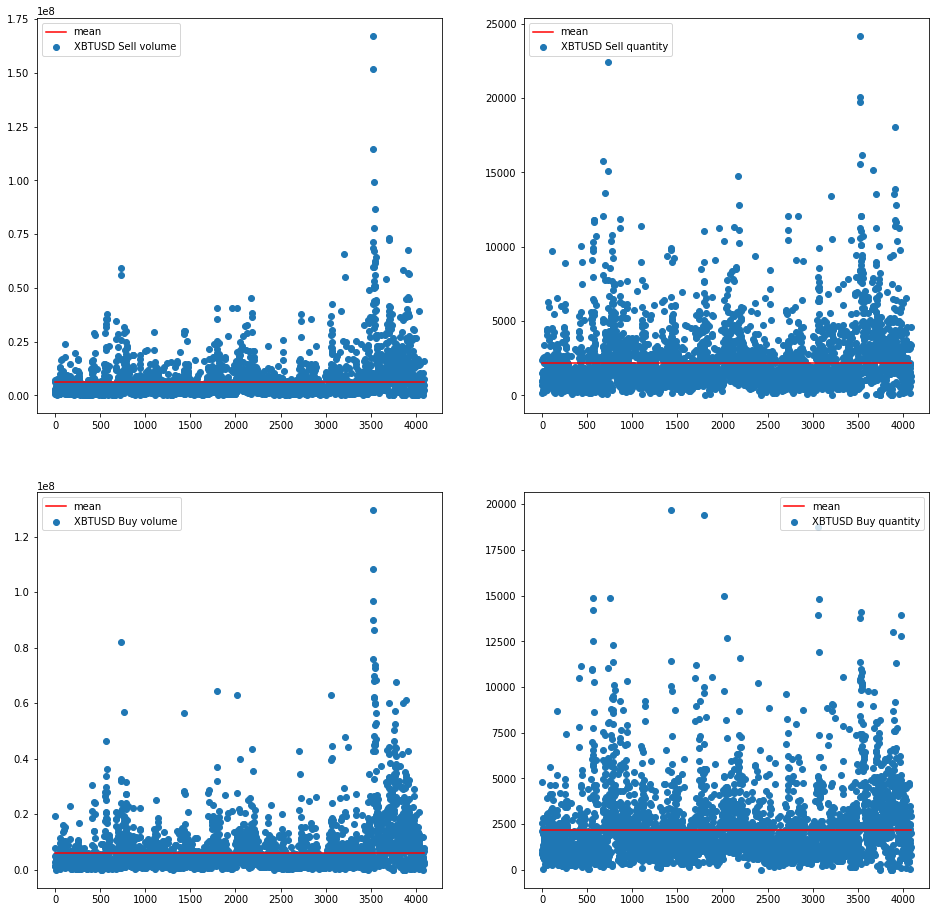

In [49]:
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 2

labels = ['XBTUSD Sell volume', 'XBTUSD Sell quantity', 'XBTUSD Buy volume', 'XBTUSD Buy quantity']
for i, value, l in zip(range(1, columns*rows +1), [df.xss, df.xst, df.xbs, df.xbt], labels):
    fig.add_subplot(rows, columns, i)
    plt.scatter(range(0, len(value)), value, label=l)
    plt.plot([0, len(value)], [value.mean(), value.mean()], c='red', label='mean')
    plt.legend()
    
plt.show()

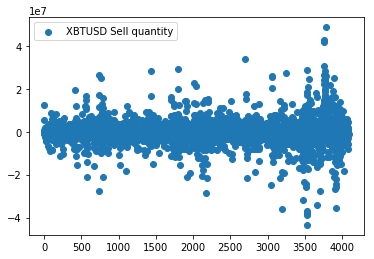

In [39]:
plt.scatter(range(0, len(storage)), df.xbs - df.xss, label='XBTUSD Sell quantity')
plt.legend()